# Production Networks

**[John Stachurski](https://johnstachurski.net)** September 2022

The study of economic networks has become very popular recently:

- production networks (Acemoglu, Azar, Carvalho, Nirei, Ozdaglah, Tahbaz-Salehi, etc.)
- financial networks (Elliot, Golub, Jackson, Pernoud, etc.)
- social networks (DeGroot, Easly, Zenou, etc.)

For an overview and references see [Sargent and Stachurski (2022)](https://networks.quantecon.org/).

In this notebook we give a quick introduction to production networks and some Python tools that can be used to analyze them.

Uncomment the lines if you don't have these libraries installed.

In [3]:
#!pip install quantecon
#!pip install quantecon_book_networks
#!pip install pandas_datareader

We use the following imports

In [8]:
import numpy as np                # Working with arrays
import matplotlib.pyplot as plt   # Plotting library
from matplotlib import cm         # Color maps

## Input-Output Tables

Data for multisector production models can be found in input-output tables.

Let's discuss how to read in and use this data.

### Intermediate Goods and Coefficient Matrices

Consider an economy with $n$ goods, produced by $n$ sectors.

We define
 
* $x_i :=$ total sales of sector $i$.
* $z_{ij} :=$ inter-industry sales from sector $i$ to sector $j$.



One of the core concepts in multisector production models is the *input-output coefficient matrix*, defined as

$$
    A =
    \begin{pmatrix}
          a_{11} & a_{12} & a_{13} \\
          a_{21} & a_{22} & a_{23} \\
          a_{31} & a_{32} & a_{33}
    \end{pmatrix}
$$

where

\begin{equation}\label{eq:leona}
    a_{ij} := \frac{z_{ij}}{x_j}
\end{equation}

In words,

\begin{equation*}
    a_{ij} := 
    \frac{\text{value of inputs from sector $i$ purchased by sector $j$ }}
        {\text{total sales of sector $j$}}.
\end{equation*}

Thus, 

* column $j$ of $A$ shows the relative importance of each sector when producing good $j$
* row $i$ shows sales of good $i$ as an intermediate input

### Reading in the Data

Most countries publish input-output data.


We will obtain input-output data from the library `quantecon_book_networks`, which was published to support the book [Sargent and Stachurski (2022)](https://networks.quantecon.org/)

In [9]:
import quantecon_book_networks.input_output as qbn_io
import quantecon_book_networks.data as qbn_data

In [10]:
io_data_dict = qbn_data.production()

What sort of object have we created?

In [11]:
type(io_data_dict)

dict

In [12]:
print(io_data_dict.keys())

dict_keys(['us_sectors_15', 'us_sectors_71', 'au_sectors_114', 'gdp_df'])


Let's get the Australian data.

In [60]:
io_data = io_data_dict['us_sectors_15']

In [61]:
print(io_data.keys())

dict_keys(['adjacency_matrix', 'total_industry_sales', 'codes'])


In [62]:
codes = io_data["codes"]

The key `adjacency matrix` gives us $Z$, while `total_industry_sales` gives us $x$.

In [63]:
Z = io_data["adjacency_matrix"]
x = io_data["total_industry_sales"]

### Computing the Coefficient Matrix

The next step is to create the coefficient matrix $A$.  For this we design a function.

In [64]:
def build_coefficient_matrix(Z, x):
    """
    Build the coefficient matrix A with A[i, j] = Z[i, j] / x[j] 
    
    """
    A = np.empty_like(Z)
    n = len(x)
    for i in range(n):
        for j in range(n):
            A[i, j] = Z[i, j] / x[j]
    return A

Now we can build $A$.

In [65]:
A = build_coefficient_matrix(Z, x)

Let's have a quick look:

In [68]:
np.set_printoptions(suppress=True)
print(np.array_str(A, precision=3))

[[0.254 0.    0.    0.002 0.052 0.001 0.003 0.    0.    0.    0.001 0.
  0.006 0.    0.002]
 [0.006 0.102 0.081 0.017 0.059 0.    0.    0.    0.    0.    0.    0.
  0.001 0.001 0.01 ]
 [0.01  0.016 0.045 0.003 0.009 0.007 0.017 0.009 0.003 0.015 0.004 0.006
  0.018 0.005 0.007]
 [0.004 0.006 0.014 0.    0.002 0.001 0.002 0.004 0.001 0.022 0.    0.001
  0.002 0.005 0.023]
 [0.245 0.15  0.049 0.35  0.393 0.044 0.048 0.107 0.062 0.016 0.049 0.088
  0.094 0.104 0.128]
 [0.003 0.    0.002 0.    0.004 0.021 0.01  0.    0.001 0.001 0.    0.
  0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.
  0.    0.    0.   ]
 [0.001 0.005 0.021 0.001 0.009 0.039 0.039 0.11  0.011 0.006 0.015 0.008
  0.007 0.007 0.012]
 [0.001 0.004 0.006 0.005 0.004 0.012 0.015 0.01  0.122 0.01  0.028 0.014
  0.015 0.025 0.026]
 [0.074 0.074 0.027 0.034 0.017 0.091 0.12  0.102 0.046 0.195 0.07  0.111
  0.102 0.115 0.047]
 [0.008 0.103 0.058 0.052 0.06  0.15  0.125 0.076 0.136 0.086 

### Efficiency

We are using small networks here so efficiency is not important.

But it will be for large networks so let's consider it.

To boost efficiency we can use broadcasting and vectorized operations rather than loops.

To do this, we reshape `x[j]` to `x[i, j]` and then set `A = Z / x`.

The general principle is

1. add missing indices
2. carry out vectorized arithmetic

In [69]:
def build_coefficient_matrix_vectorized(Z, x):
    n = len(x)
    x = np.reshape(x, (1, n))   # Reshape x[j] to x[i, j] 
    A = Z / x
    return(A)

Let's make sure that they produce the same output:

In [70]:
np.all(build_coefficient_matrix_vectorized(Z, x) == A)

True

The vectorized operation is faster:

In [71]:
%timeit build_coefficient_matrix(Z, x)   # run many times and take the average

47.2 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [72]:
%timeit build_coefficient_matrix_vectorized(Z, x)

2.1 µs ± 25.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Alternatively, we can use Numba to make the loops more efficient.

In [73]:
from numba import njit
build_coefficient_matrix_jitted = njit(build_coefficient_matrix)

In [74]:
%timeit build_coefficient_matrix_jitted(Z, x)

815 ns ± 13.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Graph-Theoretic Properties


We can examine, visualize and try to understand the data by viewing it as a directed graph.

To do this we use [NetworkX](https://networkx.org/), which is imported as `nx`:

In [101]:
import networkx as nx          

In [107]:
G = nx.DiGraph()
n = len(A)


# Add nodes, with weights by sales of the sector
for i, w in enumerate(x):
    G.add_node(codes[i], weight=w, name=codes[i])

for i in range(n):
    for j in range(n):
        a = A[i, j]
        if a > 1e-6:
            G.add_edge(codes[i], codes[j], weight=A[i, j])

In [108]:
s = 0

In [109]:
for u, v, a in G.edges(data=True):
    s += a['weight']

In [110]:
s

6.395942216882692

In [111]:
np.sum(A)

6.395942216882693

### Visualization


In [112]:
def plot_graph(A):
    G = nx.DiGraph()
    n = len(A)

    # Add nodes, with weights by sales of the sector
    for i, w in enumerate(x):
        G.add_node(codes[i], weight=w, name=codes[i])

    node_size_multiple = 0.0008
    node_sizes = x * node_size_multiple
    node_pos_dict = nx.spring_layout(G, seed=1234)
    centrality = qbn_io.eigenvector_centrality(A)
    node_color_list = qbn_io.colorise_weights(centrality, beta=False) 

    # Add the edges, along with their colors and widths
    edge_colors = [node_color_list[i] for i in range(n)]
    edge_widths = []
    edge_size_multiple = 24
    
    for i in range(n):
        for j in range(n):
            a = A[i, j]
            G.add_edge(codes[i], codes[j])
            width = a * edge_size_multiple
            edge_widths.append(width)

    # Get rid of self-loops to make the plot cleaner
    G.remove_edges_from(nx.selfloop_edges(G))         

    fig, ax = plt.subplots(figsize=(10, 14))
    plt.axis("off")

    # Plot the networks
    nx.draw_networkx_nodes(G, 
                           node_pos_dict, 
                           node_color=node_color_list, 
                           node_size=node_sizes, 
                           edgecolors='grey', 
                           linewidths=2, 
                           alpha=0.6, 
                           ax=ax)

    nx.draw_networkx_labels(G, 
                            node_pos_dict, 
                            font_size=10, 
                            ax=ax)

    nx.draw_networkx_edges(G, 
                           node_pos_dict, 
                           edge_color=edge_colors, 
                           width=edge_widths, 
                           arrows=True, 
                           arrowsize=20, 
                           alpha=0.6,  
                           ax=ax, 
                           arrowstyle='->', 
                           node_size=node_sizes, 
                           connectionstyle='arc3,rad=0.15')

    plt.show()


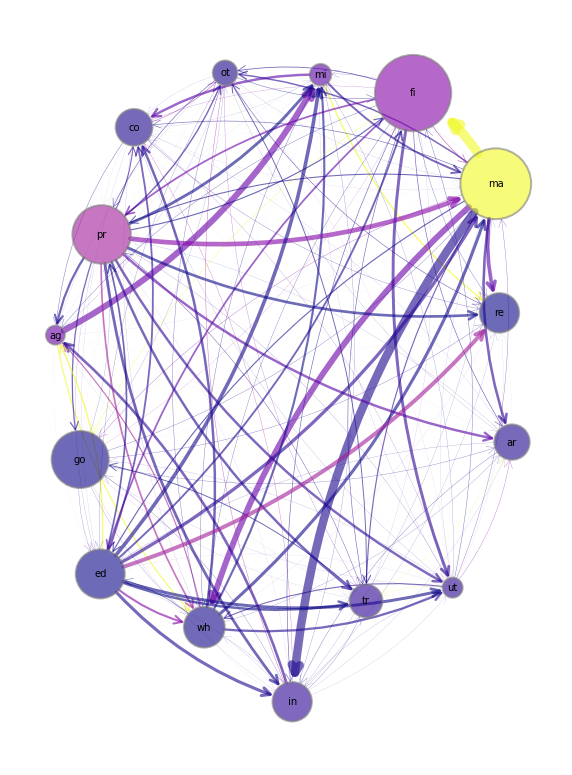

In [113]:
plot_graph(A)

Here are the codes:

| code | sector |
|------|--------|
| ag | Agriculture, forestry, fishing, and hunting |
| mi |  Mining |
| ut | Utilities | 
| co | Construction |
| ma | Manufacturing |
| wh | Wholesale trade | 
| re | Retail trade |
| tr | Transportation and warehousing |
| in | Information |
| fi | Finance, insurance, real estate, rental, and leasing |
| pr | Professional and business services |
| ed | Educational services, health care, and social assistance |
| ar | Arts, entertainment, accommodation, and food services |
| ot | Other services, except government |
| go | Government |


## Centrality

## Equilibrium


We are interested in computing equilibrium output in each sector given final demand.

This is the [input-output problem](https://en.wikipedia.org/wiki/Input%E2%80%93output_model) originally studied by Leontief.

Let
 
* $d_i :=$ final consumer demand for good $i$.

Recall that

* $x_i :=$ total sales of sector $i$.
* $z_{ij} :=$ inter-industry sales from sector $i$ to sector $j$.
* $a_{ij} := z_{ij} / x_i$


This is a kind of fixed point problem.


In [93]:
from IPython.display import IFrame
IFrame("tikz/io_reducible.pdf", width=500, height=500)


To begin, note that, for each sector $i$ we have the accounting identity

\begin{equation}\label{eq:sales}
    x_i = \sum_{j=1}^n z_{ij} + d_i,
\end{equation}

In words,

$$ \text{total sales $=$ sales to other industries
    $+$ sales to final consumers}
$$

We rewrite as 

\begin{equation}\label{eq:iorcon}
    x_i = \sum_{j=1}^n a_{ij} x_j + d_i,
    \qquad i = 1, \ldots n.
\end{equation}


We can combine the $n$ equations into the linear system

\begin{equation}\label{eq:nnlinsys}
    x = A x + d.
\end{equation}

Given $A$ (from the IO tables) and final demand $d$, our task is to solve for $x$.

**Proposition.**  If $\max_j \sum_i a_{ij} < 1$, then $L := I - A$ is invertible and $x^* := L^{-1} d$ is the unique equilibrium.

*Proof:*  Since $A \geq 0$, the Perron-Frobenius theorem tells us that $r(A)$, the spectral radius of $A$, obeys $m_1 \leq r(A) \leq m_2$, where 

* $m_1$ is the min of the column sums of $A$ and
* $m_2$ is the max of the column sums of $A$.

Hence $0 \leq r(A) \leq m_2 = \max_j \sum_i a_{ij} < 1$.   The proposition now follows.

#### Exercise

Write a function that takes a square matrix $A$ and returns the minimum and maximum of the column sums.

If possible write two versions, one that uses loops and another that uses vectorized operations.

In [94]:
for _ in range(10):
    print("solution below.")

solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.


Here's a version with loops:

In [95]:
def col_sum_min_max(A):
    n = len(A)
    m1, m2 = np.inf, -np.inf
    for j in range(n):
        col_sum = 0.0
        for i in range(n):
            col_sum += A[i, j]
        if col_sum < m1:
            m1 = col_sum
        if col_sum > m2:
            m2 = col_sum
    return m1, m2

And here's a vectorized version:

In [106]:
def col_sum_min_max_vectorized(A):
    col_sums = np.sum(A, axis=0)
    return col_sums.min(), col_sums.max()

Let's check they give the same number for our data:

In [109]:
col_sum_min_max(A)

(1.1994754182339358e-06, 0.0019154876989634822)

In [110]:
col_sum_min_max_vectorized(A)

(1.1994754182339358e-06, 0.0019154876989634822)